# **Importing Libraries**

In [ ]:
#Set path to MAIN FOLDER OF EXPERIMENT
#cd /path/to/EXPERIMENT_FOLDER/

In [1]:
#Import tensorflow and keras modules
from tensorflow.keras.layers import Dropout, Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.applications import nasnet
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.optimizers import Adam
from keras.models import model_from_json
from keras_flops import get_flops
import tensorflow as tf

#Import other modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import talos
import math
import pickle
import os
%matplotlib inline

In [2]:
#Save Model Function
def save_m(file, model):
    if not os.path.exists(file):
        os.makedirs(file)

    model.save_weights(file+'/model.h5')
    model_json = model.to_json()
    with open(file + "/model.json", "w") as json_file:
        json_file.write(model_json)

#Save History Function
def save_h(file, history):
    if not os.path.exists(file):
        os.makedirs(file)

    with open(file + '/' + 'model.history', 'wb') as file_pi:
        pickle.dump(history, file_pi)

#Load Model Function
def load_m(file):
	if not os.path.exists(file) and file != 'EnsembleModel':
		print("\n[ERROR] Model path '" + file +  "' does not exist.")
		exit()

	with open(file + "/model.json", "r") as json_file:
		model = json_file.read()
		model = model_from_json(model)
		model.load_weights(file+'/model.h5')
		return model

#Load History Function
def load_h(file):
    with open(file + '/' + 'model.history', 'rb') as file_pi:
        his = pickle.load(file_pi)
    return his

#Get data from generator function
def get_data(generator, nb_samples):  
    from tqdm.notebook import tqdm
    x = []
    y = []

    for i in tqdm(range(math.ceil(nb_samples/BATCH_SIZE))):
        x.extend(generator[i][0])
        y.extend(generator[i][1])

    x = np.array(x)
    y = np.array(y)
    return x, y

#Create generator from data function
def get_generator(x, y, preprocess_input, shuffle=True):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    datagen = datagen.flow(x, y, batch_size=BATCH_SIZE, shuffle=shuffle)
    return datagen

# **Loading Data**

In [3]:
#Define Constants
IMAGE_SIZE = (256, 256)
MODEL_INPUT = Input(shape=(256, 256, 3))
BATCH_SIZE = 4
EPOCHS = 30
LEARNING_RATE = 0.0001

#Data paths
TRAIN_DATA_PATH = 'ds/train/'
VAL_DATA_PATH = 'ds/val/'
TEST_DATA_PATH = 'ds/test/'

#Model path
DIST_STUDENT_MODEL_PATH = 'models/Distilled_Student_Models/'
NORMAL_STUDENT_MODEL_PATH = 'models/Student_Models/'
TEACHER_MODEL_PATH = 'models/Teacher_Models/'

TEACHER_NAME = 'EfficientNetB7'
STUDENT_NAME = 'KD-NASNetMobile'

In [ ]:
#Create Generator from datapath
datagen = ImageDataGenerator()

train_generator = datagen.flow_from_directory(TRAIN_DATA_PATH, 
                                                    target_size=IMAGE_SIZE, 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical',
                                                    shuffle=False)

validation_generator = datagen.flow_from_directory(VAL_DATA_PATH, 
                                                        target_size=IMAGE_SIZE, 
                                                        batch_size=BATCH_SIZE, 
                                                        class_mode='categorical',
                                                        shuffle=False)

test_generator = datagen.flow_from_directory(TEST_DATA_PATH, 
                                                  target_size=IMAGE_SIZE, 
                                                  batch_size=BATCH_SIZE, 
                                                  class_mode='categorical',
                                                  shuffle=False)

nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)
num_classes= len(train_generator.class_indices)

print('NUMBER OF TRAIN SAMPLES:', nb_train_samples)
print('NUMBER OF VALIDATION SAMPLES:',nb_validation_samples)
print('NUMBER OF TEST SAMPLES:',nb_test_samples)
print('TOTAL CLASSES:', num_classes)

Found 1990 images belonging to 199 classes.
Found 1194 images belonging to 199 classes.
Found 796 images belonging to 199 classes.
NUMBER OF TRAIN SAMPLES: 1990
NUMBER OF VALIDATION SAMPLES: 1194
NUMBER OF TEST SAMPLES: 796
TOTAL CLASSES: 199


# **Knowledge Distillation**

**KD Class**

In [ ]:
class KDistiller(Model):
    def __init__(self, student, teacher):
        super(KDistiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha,
        temperature,
    ):
        super(KDistiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_preds = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_preds = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_preds)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_preds / self.temperature, axis=1),
                tf.nn.softmax(student_preds / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics 
        self.compiled_metrics.update_state(y, student_preds)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, 'combined_loss':loss}
        )

        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_preds = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_preds)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_preds)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

    def call(self, inputs, training):
        return self.student(inputs, training=training)

**Teacher Model**

In [ ]:
# Load the teacher
def get_teacher(directory):
    model = load_m(directory)
    return model

print("TEACHER MODEL\n\n\n")
get_teacher(TEACHER_MODEL_PATH + TEACHER_NAME).summary()

TEACHER MODEL



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 8, 8, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 199)               509639    
Total params: 64,607,326
Trainable params: 64,296,599
Non-trainable params: 310,727
_________________________________________________________________


**Student Model**

In [ ]:
#Create the student
def get_student():
    transfer = nasnet.NASNetMobile(include_top = False, weights = 'imagenet', input_tensor=Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
    gap2D = GlobalAveragePooling2D()(transfer.layers[-1].output)
    drop = Dropout(0.5)(gap2D)
    classifier = Dense(199)(drop)

    model = Model(inputs = transfer.inputs, outputs = classifier)
    model.compile(
          optimizer = Adam(learning_rate=LEARNING_RATE),
          loss = CategoricalCrossentropy(from_logits=True),
          metrics = [CategoricalAccuracy()]
    )

    return model

print("STUDENT MODEL\n\n\n")
get_student().summary()

STUDENT MODEL



19996672/19993432 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 127, 127, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           stem_bn1[0][0]                   
____________

**Training Student With KD**

In [ ]:
#Get training data in x, y format
print("Loading Training Data")
x_train, y_train = get_data(train_generator, nb_train_samples)

print("Loading Validation Data")
x_val, y_val = get_data(validation_generator, nb_validation_samples)

print("Loading Testing Data")
x_test, y_test = get_data(test_generator, nb_test_samples)

Loading Training Data


  0%|          | 0/498 [00:00<?, ?it/s]

Loading Validation Data


  0%|          | 0/299 [00:00<?, ?it/s]

Loading Testing Data


  0%|          | 0/199 [00:00<?, ?it/s]

In [ ]:
# Distill teacher to student
p = {
    'temperature':[2, 3, 5, 10],
    'alpha':[0.1, 0.3, 0.5] 
    }

def distiller_model(x_train, y_train, x_val, y_val, params):
    #Get teacher and student model                
    teacher = get_teacher(TEACHER_MODEL_PATH  + TEACHER_NAME)
    student = get_student()

    #Create Knowledge distiller
    distiller = KDistiller(student=student, teacher=teacher)

    #Compile Knowledge distiller
    distiller.compile(
        optimizer = Adam(learning_rate=LEARNING_RATE),
        metrics=[CategoricalAccuracy()],
        student_loss_fn=CategoricalCrossentropy(from_logits=True),
        distillation_loss_fn= KLDivergence(),
        alpha=params['alpha'],
        temperature=params['temperature'],
    )

    #Get train and val generator
    train_generator = get_generator(x_train, y_train, nasnet.preprocess_input)
    validation_generator = get_generator(x_val, y_val, nasnet.preprocess_input)

    #Training
    distiller_history = distiller.fit(train_generator,
                                        validation_data = validation_generator,
                                        steps_per_epoch = nb_train_samples// BATCH_SIZE,
                                        validation_steps = nb_validation_samples// BATCH_SIZE,
                                        epochs=EPOCHS
                                      )

    return distiller_history, distiller.student

scan_object = talos.Scan(x_train, y_train, experiment_name=STUDENT_NAME+'exp', x_val=x_val, y_val=y_val, model=distiller_model, params=p)

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

Epoch 1/30
497/497 [==============================] - 156s 274ms/step - categorical_accuracy: 0.0060 - student_loss: 5.3394 - distillation_loss: 0.0244 - combined_loss: 0.5559 - val_categorical_accuracy: 0.0168 - val_student_loss: 5.2733
Epoch 2/30
497/497 [==============================] - 132s 267ms/step - categorical_accuracy: 0.0347 - student_loss: 5.0134 - distillation_loss: 0.0199 - combined_loss: 0.5193 - val_categorical_accuracy: 0.0134 - val_student_loss: 4.5644
Epoch 3/30
497/497 [==============================] - 133s 267ms/step - categorical_accuracy: 0.1793 - student_loss: 4.2797 - distillation_loss: 0.0427 - combined_loss: 0.4664 - val_categorical_accuracy: 0.0973 - val_student_loss: 4.8770
Epoch 4/30
497/497 [==============================] - 132s 266ms/step - categorical_accuracy: 0.4703 - student_loss: 3.2997 - distillation_loss: 0.0748 - combined_loss: 0.3973 - val_categorical_accuracy: 0.2534 - val_student_loss: 4.8382
Epoch 5/30
497/497 [============================

  8%|██████▎                                                                     | 1/12 [1:06:49<12:15:06, 4009.72s/it]

Epoch 1/30
497/497 [==============================] - 152s 270ms/step - categorical_accuracy: 0.0111 - student_loss: 5.3164 - distillation_loss: 0.0161 - combined_loss: 0.5462 - val_categorical_accuracy: 0.0126 - val_student_loss: 5.5140
Epoch 2/30
497/497 [==============================] - 132s 266ms/step - categorical_accuracy: 0.0614 - student_loss: 4.8477 - distillation_loss: 0.0170 - combined_loss: 0.5000 - val_categorical_accuracy: 0.0294 - val_student_loss: 5.1573
Epoch 3/30
497/497 [==============================] - 132s 266ms/step - categorical_accuracy: 0.2538 - student_loss: 3.8432 - distillation_loss: 0.0415 - combined_loss: 0.4216 - val_categorical_accuracy: 0.1342 - val_student_loss: 3.9471
Epoch 4/30
497/497 [==============================] - 133s 267ms/step - categorical_accuracy: 0.5619 - student_loss: 2.6506 - distillation_loss: 0.0681 - combined_loss: 0.3263 - val_categorical_accuracy: 0.2710 - val_student_loss: 2.6767
Epoch 5/30
497/497 [============================

 17%|████████████▋                                                               | 2/12 [2:14:17<11:12:02, 4032.24s/it]

Epoch 1/30
497/497 [==============================] - 158s 281ms/step - categorical_accuracy: 0.0101 - student_loss: 5.3063 - distillation_loss: 0.0083 - combined_loss: 0.5381 - val_categorical_accuracy: 0.0076 - val_student_loss: 5.6605
Epoch 2/30
497/497 [==============================] - 138s 278ms/step - categorical_accuracy: 0.0770 - student_loss: 4.7039 - distillation_loss: 0.0119 - combined_loss: 0.4811 - val_categorical_accuracy: 0.0445 - val_student_loss: 4.7998
Epoch 3/30
497/497 [==============================] - 135s 272ms/step - categorical_accuracy: 0.2689 - student_loss: 3.4609 - distillation_loss: 0.0288 - combined_loss: 0.3720 - val_categorical_accuracy: 0.1267 - val_student_loss: 4.3639
Epoch 4/30
497/497 [==============================] - 135s 272ms/step - categorical_accuracy: 0.5791 - student_loss: 2.1944 - distillation_loss: 0.0451 - combined_loss: 0.2601 - val_categorical_accuracy: 0.2752 - val_student_loss: 3.0500
Epoch 5/30
497/497 [============================

 25%|███████████████████                                                         | 3/12 [3:22:44<10:09:57, 4066.44s/it]

Epoch 1/30
497/497 [==============================] - 157s 277ms/step - categorical_accuracy: 0.0076 - student_loss: 5.3535 - distillation_loss: 0.0022 - combined_loss: 0.5374 - val_categorical_accuracy: 0.0067 - val_student_loss: 6.3116
Epoch 2/30
497/497 [==============================] - 136s 273ms/step - categorical_accuracy: 0.0730 - student_loss: 4.8228 - distillation_loss: 0.0030 - combined_loss: 0.4850 - val_categorical_accuracy: 0.0411 - val_student_loss: 4.4883
Epoch 3/30
497/497 [==============================] - 141s 284ms/step - categorical_accuracy: 0.2749 - student_loss: 3.4417 - distillation_loss: 0.0096 - combined_loss: 0.3528 - val_categorical_accuracy: 0.1544 - val_student_loss: 4.3335
Epoch 4/30
497/497 [==============================] - 141s 284ms/step - categorical_accuracy: 0.5705 - student_loss: 1.9544 - distillation_loss: 0.0176 - combined_loss: 0.2113 - val_categorical_accuracy: 0.3398 - val_student_loss: 3.1521
Epoch 5/30
497/497 [============================

 33%|█████████████████████████▋                                                   | 4/12 [4:31:32<9:05:24, 4090.51s/it]

Epoch 1/30
497/497 [==============================] - 159s 280ms/step - categorical_accuracy: 0.0086 - student_loss: 5.3186 - distillation_loss: 0.0435 - combined_loss: 1.6260 - val_categorical_accuracy: 0.0101 - val_student_loss: 5.5823
Epoch 2/30
497/497 [==============================] - 136s 274ms/step - categorical_accuracy: 0.0690 - student_loss: 4.7755 - distillation_loss: 0.0572 - combined_loss: 1.4727 - val_categorical_accuracy: 0.0495 - val_student_loss: 4.9939
Epoch 3/30
497/497 [==============================] - 135s 272ms/step - categorical_accuracy: 0.2971 - student_loss: 3.5370 - distillation_loss: 0.1495 - combined_loss: 1.1658 - val_categorical_accuracy: 0.1820 - val_student_loss: 4.3321
Epoch 4/30
497/497 [==============================] - 136s 274ms/step - categorical_accuracy: 0.6067 - student_loss: 2.2344 - distillation_loss: 0.2407 - combined_loss: 0.8388 - val_categorical_accuracy: 0.3456 - val_student_loss: 3.4152
Epoch 5/30
497/497 [============================

 42%|████████████████████████████████                                             | 5/12 [5:39:01<7:55:29, 4075.65s/it]

Epoch 1/30
497/497 [==============================] - 153s 271ms/step - categorical_accuracy: 0.0091 - student_loss: 5.3412 - distillation_loss: 0.0229 - combined_loss: 1.6184 - val_categorical_accuracy: 0.0050 - val_student_loss: 5.5795
Epoch 2/30
497/497 [==============================] - 133s 267ms/step - categorical_accuracy: 0.0801 - student_loss: 4.7881 - distillation_loss: 0.0321 - combined_loss: 1.4589 - val_categorical_accuracy: 0.0847 - val_student_loss: 4.9004
Epoch 3/30
497/497 [==============================] - 133s 267ms/step - categorical_accuracy: 0.2931 - student_loss: 3.4216 - distillation_loss: 0.0909 - combined_loss: 1.0901 - val_categorical_accuracy: 0.1552 - val_student_loss: 4.3997
Epoch 4/30
497/497 [==============================] - 133s 267ms/step - categorical_accuracy: 0.5791 - student_loss: 2.0813 - distillation_loss: 0.1516 - combined_loss: 0.7305 - val_categorical_accuracy: 0.3138 - val_student_loss: 3.6402
Epoch 5/30
497/497 [============================

 50%|██████████████████████████████████████▌                                      | 6/12 [6:45:51<6:45:20, 4053.44s/it]

Epoch 1/30
497/497 [==============================] - 153s 271ms/step - categorical_accuracy: 0.0146 - student_loss: 5.3302 - distillation_loss: 0.0106 - combined_loss: 1.6065 - val_categorical_accuracy: 0.0092 - val_student_loss: 4.5257
Epoch 2/30
497/497 [==============================] - 133s 268ms/step - categorical_accuracy: 0.0760 - student_loss: 4.6622 - distillation_loss: 0.0166 - combined_loss: 1.4103 - val_categorical_accuracy: 0.0864 - val_student_loss: 4.1861
Epoch 3/30
497/497 [==============================] - 133s 267ms/step - categorical_accuracy: 0.2835 - student_loss: 3.2966 - distillation_loss: 0.0428 - combined_loss: 1.0190 - val_categorical_accuracy: 0.2483 - val_student_loss: 3.5318
Epoch 4/30
497/497 [==============================] - 133s 267ms/step - categorical_accuracy: 0.5473 - student_loss: 1.9758 - distillation_loss: 0.0714 - combined_loss: 0.6427 - val_categorical_accuracy: 0.3070 - val_student_loss: 2.1695
Epoch 5/30
497/497 [============================

 58%|████████████████████████████████████████████▉                                | 7/12 [7:52:47<5:36:45, 4041.17s/it]

Epoch 1/30
497/497 [==============================] - 153s 271ms/step - categorical_accuracy: 0.0136 - student_loss: 5.3167 - distillation_loss: 0.0030 - combined_loss: 1.5971 - val_categorical_accuracy: 0.0185 - val_student_loss: 5.4930
Epoch 2/30
497/497 [==============================] - 133s 267ms/step - categorical_accuracy: 0.0831 - student_loss: 4.6299 - distillation_loss: 0.0048 - combined_loss: 1.3923 - val_categorical_accuracy: 0.0570 - val_student_loss: 4.6873
Epoch 3/30
497/497 [==============================] - 133s 267ms/step - categorical_accuracy: 0.2986 - student_loss: 3.2245 - distillation_loss: 0.0121 - combined_loss: 0.9758 - val_categorical_accuracy: 0.2013 - val_student_loss: 3.6109
Epoch 4/30
497/497 [==============================] - 133s 267ms/step - categorical_accuracy: 0.5715 - student_loss: 1.8648 - distillation_loss: 0.0213 - combined_loss: 0.5743 - val_categorical_accuracy: 0.3230 - val_student_loss: 2.6772
Epoch 5/30
497/497 [============================

 67%|███████████████████████████████████████████████████▎                         | 8/12 [8:59:38<4:28:46, 4031.59s/it]

Epoch 1/30
497/497 [==============================] - 154s 272ms/step - categorical_accuracy: 0.0166 - student_loss: 5.3353 - distillation_loss: 0.0573 - combined_loss: 2.6963 - val_categorical_accuracy: 0.0117 - val_student_loss: 5.2788
Epoch 2/30
497/497 [==============================] - 132s 266ms/step - categorical_accuracy: 0.0614 - student_loss: 4.7920 - distillation_loss: 0.0757 - combined_loss: 2.4338 - val_categorical_accuracy: 0.0562 - val_student_loss: 4.5886
Epoch 3/30
497/497 [==============================] - 132s 266ms/step - categorical_accuracy: 0.2392 - student_loss: 3.6138 - distillation_loss: 0.1962 - combined_loss: 1.9050 - val_categorical_accuracy: 0.2072 - val_student_loss: 3.4863
Epoch 4/30
497/497 [==============================] - 132s 265ms/step - categorical_accuracy: 0.5106 - student_loss: 2.3594 - distillation_loss: 0.3296 - combined_loss: 1.3445 - val_categorical_accuracy: 0.3121 - val_student_loss: 2.8532
Epoch 5/30
497/497 [============================

 75%|█████████████████████████████████████████████████████████                   | 9/12 [10:06:20<3:21:06, 4022.14s/it]

Epoch 1/30
497/497 [==============================] - 153s 270ms/step - categorical_accuracy: 0.0086 - student_loss: 5.3402 - distillation_loss: 0.0278 - combined_loss: 2.6840 - val_categorical_accuracy: 0.0092 - val_student_loss: 5.7932
Epoch 2/30
497/497 [==============================] - 132s 266ms/step - categorical_accuracy: 0.0906 - student_loss: 4.6936 - distillation_loss: 0.0416 - combined_loss: 2.3676 - val_categorical_accuracy: 0.0596 - val_student_loss: 4.6618
Epoch 3/30
497/497 [==============================] - 132s 266ms/step - categorical_accuracy: 0.3192 - student_loss: 3.2324 - distillation_loss: 0.1167 - combined_loss: 1.6746 - val_categorical_accuracy: 0.2626 - val_student_loss: 3.3380
Epoch 4/30
497/497 [==============================] - 133s 267ms/step - categorical_accuracy: 0.5957 - student_loss: 1.8615 - distillation_loss: 0.1986 - combined_loss: 1.0300 - val_categorical_accuracy: 0.3674 - val_student_loss: 3.9872
Epoch 5/30
497/497 [============================

 83%|██████████████████████████████████████████████████████████████▌            | 10/12 [11:12:57<2:13:49, 4014.56s/it]

Epoch 1/30
497/497 [==============================] - 153s 271ms/step - categorical_accuracy: 0.0151 - student_loss: 5.3326 - distillation_loss: 0.0108 - combined_loss: 2.6717 - val_categorical_accuracy: 0.0109 - val_student_loss: 5.3217
Epoch 2/30
497/497 [==============================] - 132s 266ms/step - categorical_accuracy: 0.0947 - student_loss: 4.5791 - distillation_loss: 0.0189 - combined_loss: 2.2990 - val_categorical_accuracy: 0.0470 - val_student_loss: 4.4153
Epoch 3/30
497/497 [==============================] - 132s 266ms/step - categorical_accuracy: 0.2875 - student_loss: 3.2083 - distillation_loss: 0.0470 - combined_loss: 1.6276 - val_categorical_accuracy: 0.1653 - val_student_loss: 3.8490
Epoch 4/30
497/497 [==============================] - 132s 265ms/step - categorical_accuracy: 0.5710 - student_loss: 1.8800 - distillation_loss: 0.0806 - combined_loss: 0.9803 - val_categorical_accuracy: 0.3196 - val_student_loss: 3.1846
Epoch 5/30
497/497 [============================

 92%|████████████████████████████████████████████████████████████████████▊      | 11/12 [12:19:24<1:06:46, 4006.14s/it]

Epoch 1/30
497/497 [==============================] - 154s 271ms/step - categorical_accuracy: 0.0106 - student_loss: 5.3413 - distillation_loss: 0.0025 - combined_loss: 2.6719 - val_categorical_accuracy: 0.0076 - val_student_loss: 5.4777
Epoch 2/30
497/497 [==============================] - 132s 267ms/step - categorical_accuracy: 0.0851 - student_loss: 4.6275 - distillation_loss: 0.0045 - combined_loss: 2.3160 - val_categorical_accuracy: 0.0814 - val_student_loss: 4.8881
Epoch 3/30
497/497 [==============================] - 132s 266ms/step - categorical_accuracy: 0.2830 - student_loss: 3.2479 - distillation_loss: 0.0123 - combined_loss: 1.6301 - val_categorical_accuracy: 0.2349 - val_student_loss: 4.0061
Epoch 4/30
497/497 [==============================] - 132s 266ms/step - categorical_accuracy: 0.5695 - student_loss: 1.8525 - distillation_loss: 0.0219 - combined_loss: 0.9372 - val_categorical_accuracy: 0.4035 - val_student_loss: 2.4782
Epoch 5/30
497/497 [============================

100%|█████████████████████████████████████████████████████████████████████████████| 12/12 [13:25:59<00:00, 4029.99s/it]


In [ ]:
r = talos.Reporting(STUDENT_NAME + 'exp/results.csv')
model_index = r.data.loc[r.data['val_categorical_accuracy'] == np.max(r.data['val_categorical_accuracy'])].index[0]
val_acc = np.max(r.data['val_categorical_accuracy'])

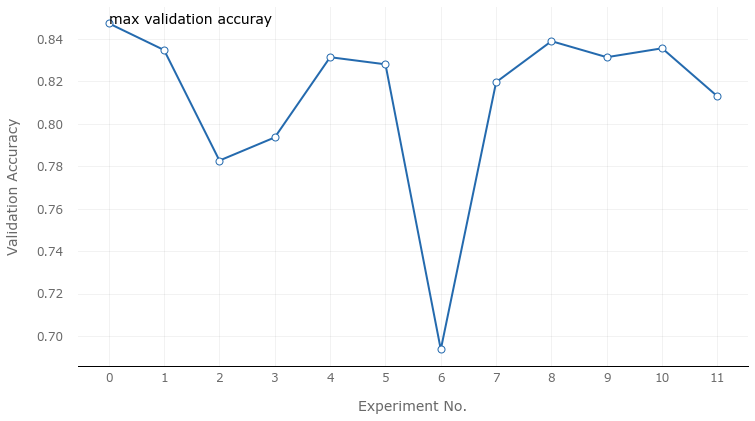

In [ ]:
#See the line plot -> model_index vs validation accuracy 
r.plot_line('val_categorical_accuracy')
plt.xlabel('Experiment No.')
plt.ylabel('Validation Accuracy')
plt.xticks(range(12))
plt.annotate( 'max validation accuray', (model_index, val_acc))
plt.show()

In [ ]:
#See the result of best student
r.data.iloc[[model_index]]

,round_epochs,categorical_accuracy,student_loss,distillation_loss,combined_loss,val_categorical_accuracy,val_student_loss,alpha,temperature
0,30,1.0,0.553777,0.097449,0.143082,0.847315,1.247289,0.1,2


In [ ]:
#Create best Student
best_student = model_from_json(scan_object.saved_models[model_index])
weights = scan_object.saved_weights[model_index]
best_student.set_weights(weights)

best_student.compile(
          optimizer = Adam(learning_rate=LEARNING_RATE),
          loss = CategoricalCrossentropy(from_logits=True),
          metrics = [CategoricalAccuracy()]
    )

#Load teacher
temp_teacher = get_teacher(TEACHER_MODEL_PATH + TEACHER_NAME)
temp_teacher.compile(
          optimizer = Adam(learning_rate=LEARNING_RATE),
          loss = CategoricalCrossentropy(from_logits=True),
          metrics = [CategoricalAccuracy()]
    )

print("Evaluating Student on test dataset\n")
test_generator = get_generator(x_test, y_test, nasnet.preprocess_input, shuffle=False)
s_acc = best_student.evaluate(test_generator, steps=np.ceil(nb_test_samples/BATCH_SIZE))

print("\nEvaluating Teacher on test dataset\n")
test_generator = get_generator(x_test, y_test, efficientnet.preprocess_input, shuffle=False)
t_acc = temp_teacher.evaluate(test_generator, steps=np.ceil(nb_test_samples/BATCH_SIZE))

Evaluating Student on test dataset

199/199 [==============================] - 40s 41ms/step - loss: 1.5255 - categorical_accuracy: 0.8256

Evaluating Teacher on test dataset

199/199 [==============================] - 43s 85ms/step - loss: 0.2800 - categorical_accuracy: 0.9386


**Saving Model**

In [ ]:
print("MODEL AND HISTORY SAVED")
#save models
save_m(DIST_STUDENT_MODEL_PATH + STUDENT_NAME, best_student)

#save history
distiller_history = scan_object.round_history[model_index]
save_h(DIST_STUDENT_MODEL_PATH + STUDENT_NAME, distiller_history)

MODEL AND HISTORY SAVED


**Final Results**

In [ ]:
student_acc = "{0:.3f} ".format(s_acc[1]*100)
student_size = "{0:.2f} M".format(best_student.count_params()/10**6)
student_flops = "{0:.2f} G".format(get_flops(Model(best_student.input, best_student.output), batch_size=1)/ 10 ** 9)

teacher_acc = "{0:.3f} ".format(t_acc[1]*100)
teacher_size = "{0:.2f} M".format(temp_teacher.count_params()/10**6)
teacher_flops = "{0:.2f} G".format(get_flops(Model(temp_teacher.input, temp_teacher.output), batch_size=1)/ 10 ** 9)

results = {STUDENT_NAME:{'Test Accuracy(%)':student_acc,
                         'Parameters':student_size,
                         'FLOPs':student_flops},
           TEACHER_NAME:{'Test Accuracy(%)':teacher_acc,
                         'Parameters':teacher_size,
                         'FLOPs':teacher_flops}}

results = pd.DataFrame(results)
results

,KD-NASNetMobile,EfficientNetB7
Test Accuracy(%),82.630,92.932
Parameters,4.48 M,64.61 M
FLOPs,1.50 G,13.69 G


# **Training Visualization**

In [6]:
#VISUAL CUSTOMIZER
distiller_history = load_h(DIST_STUDENT_MODEL_PATH + STUDENT_NAME)

marker_t = '^'
marker_v = '+'
market_t_loss = 'v'
market_v_loss = 'x'
markersize = 5
fillstyle_t = 'none'
fillstyle_v = 'none'

color_t = 'blue'
color_v = 'orange'

labelsize = 10
fontsize = 7

color_t_loss = 'green'
color_v_loss = 'red'

border_pad = 0.5
legend_font_size = 9

ls_t = '-' 
ls_v = '--'
lw_t = '1.5'
lw_v = '1.5'

print("You may change the values if needed for the ease of your evaluation")

You may change the values if needed for the ease of your evaluation


**Accuracy Curve**

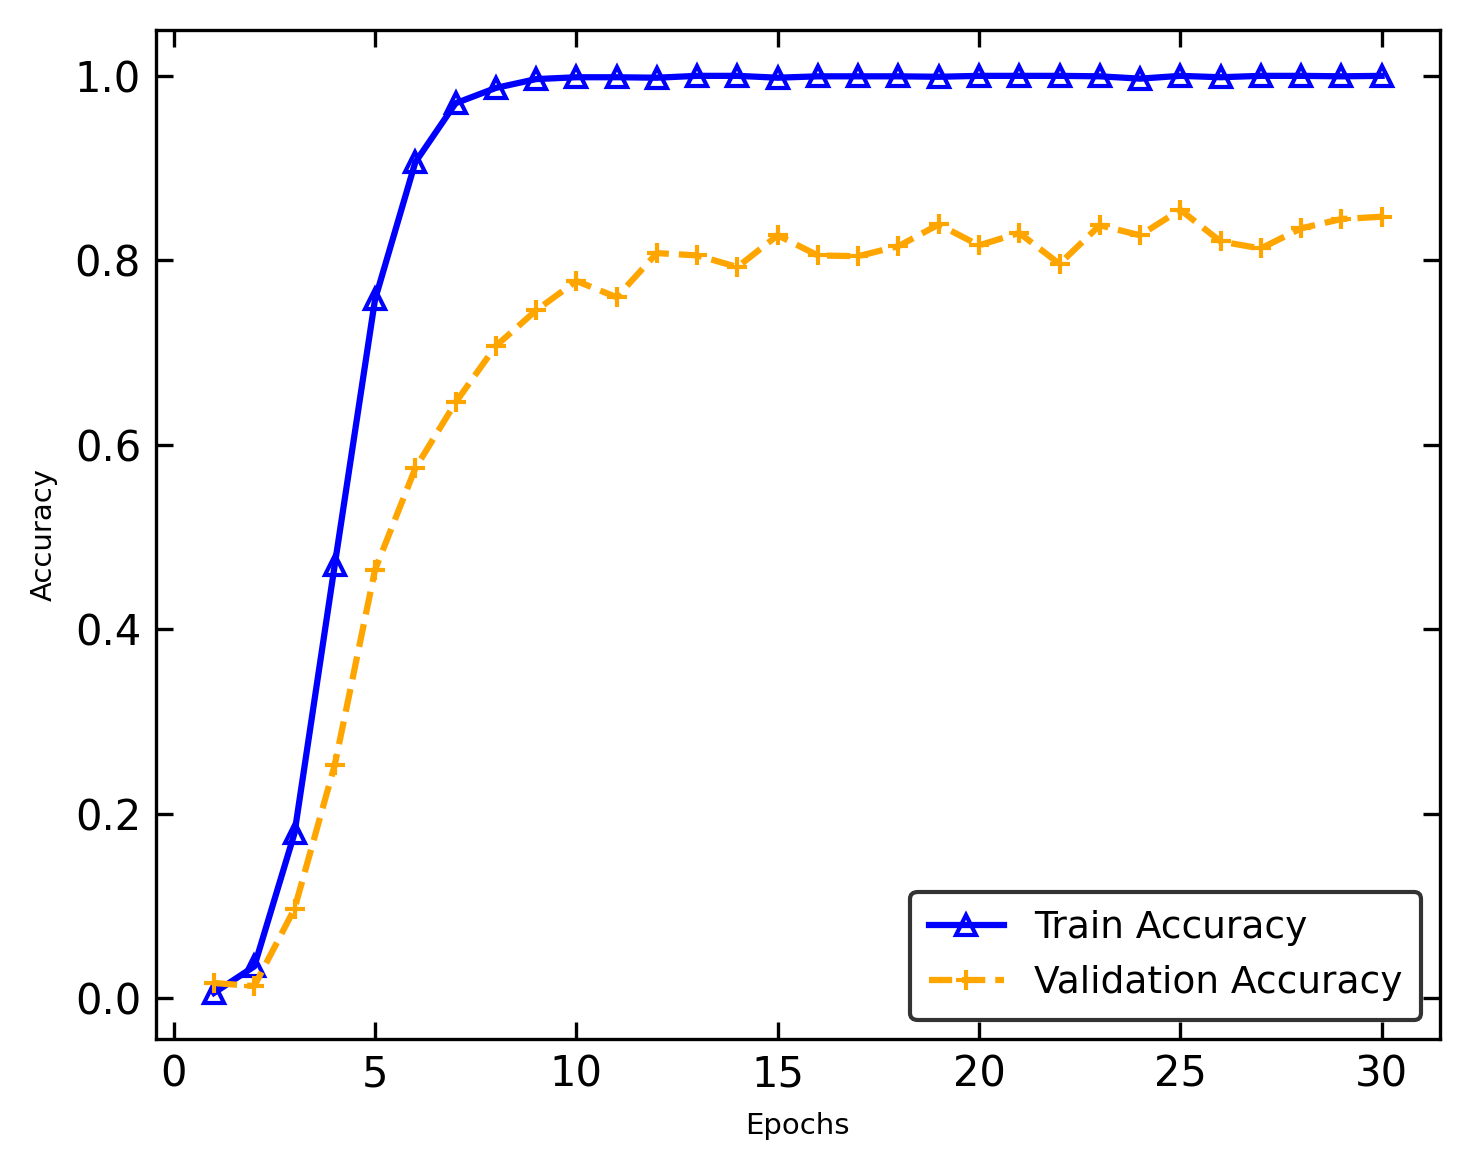

In [7]:
#PRINTS THE ACCURACY GROWTH
N = EPOCHS
plt.style.use("default")
plt.figure(figsize=(5,4), dpi=300, edgecolor='black', facecolor='white', linewidth=0)
plt.tight_layout()

plt.gcf().subplots_adjust(bottom=0.15)

plt.rc('xtick',labelsize=labelsize, direction="in") 
plt.rc('ytick', labelsize=labelsize, direction="in") 
plt.tick_params(length=4, right=True, top=True)

plt.plot(np.arange(1, N+1), distiller_history["categorical_accuracy"], color=color_t,lw=lw_t, marker=marker_t, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Accuracy")
plt.plot(np.arange(1, N+1), distiller_history["val_categorical_accuracy"], color=color_v ,lw=lw_v, marker=marker_v, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v,  label="Validation Accuracy")

plt.xlabel("Epochs", fontsize=fontsize, color='black')
plt.ylabel("Accuracy", fontsize=fontsize, color='black')
plt.legend(loc="lower right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()

**Loss Curve**

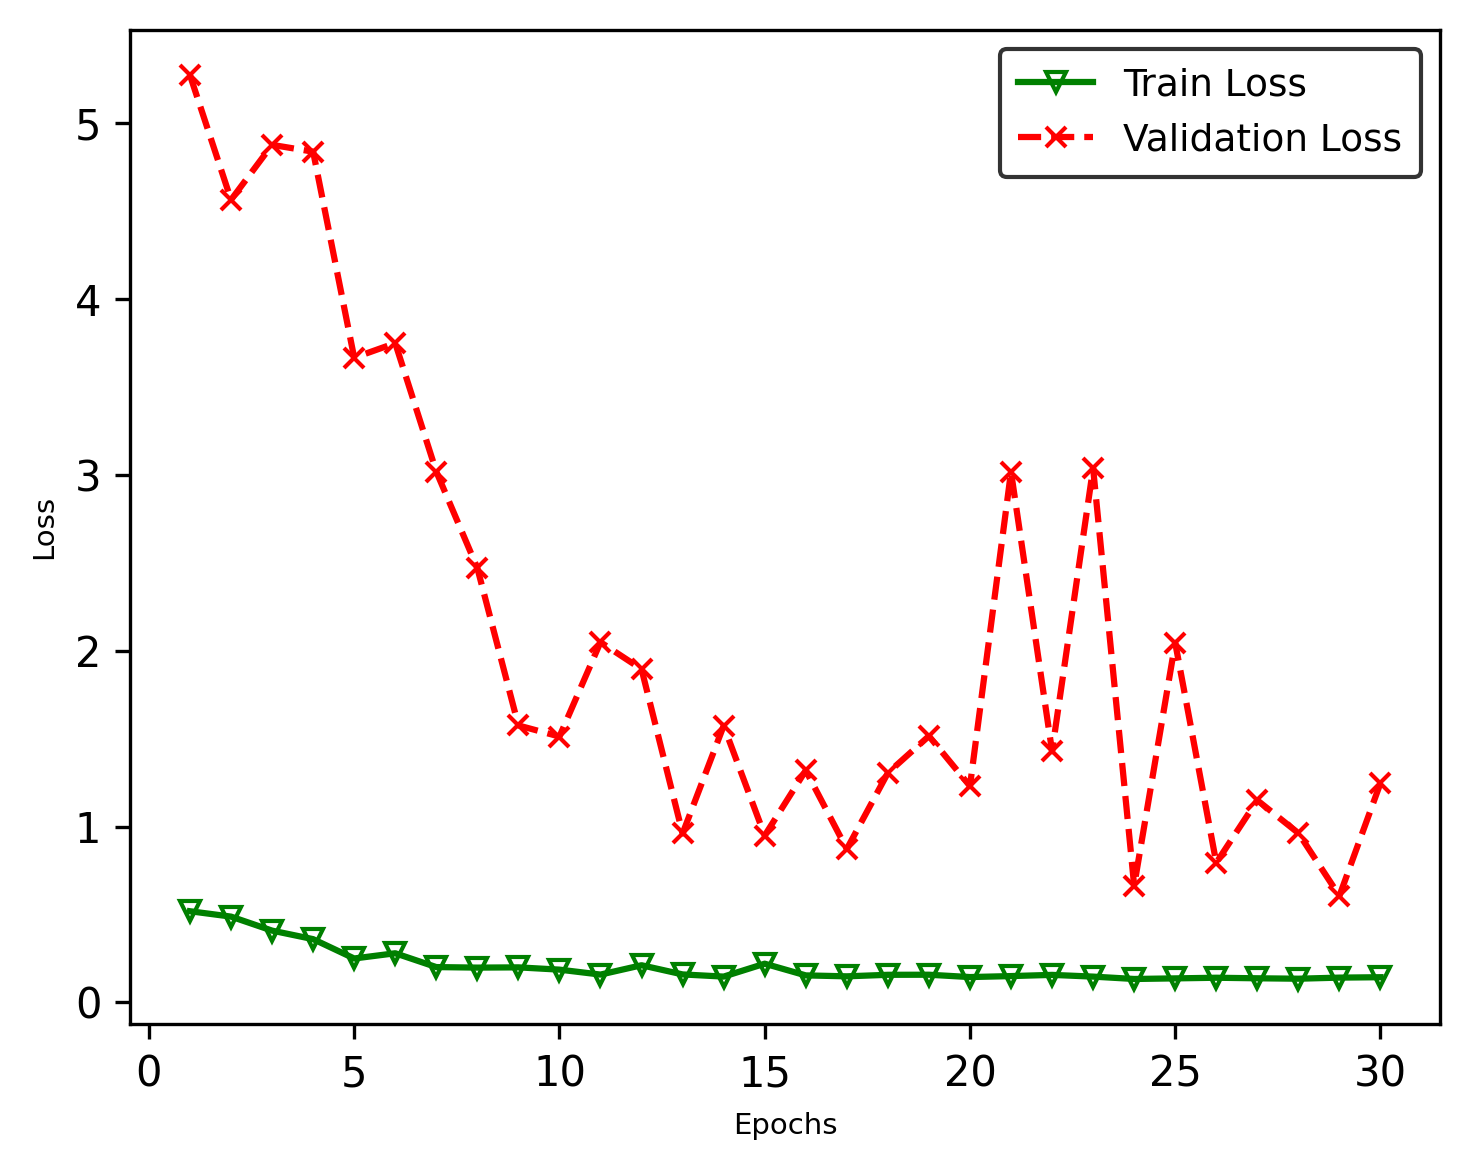

In [8]:
#PRINTS THE DECREASE OF LOSS
N = EPOCHS
plt.style.use("default")
plt.figure(figsize=(5,4), dpi=300)
plt.plot(np.arange(1, N+1), distiller_history["combined_loss"], color=color_t_loss,lw=lw_t, marker=market_t_loss, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Loss")
plt.plot(np.arange(1, N+1), distiller_history["val_student_loss"], color=color_v_loss,lw=lw_v, marker=market_v_loss, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v, label="Validation Loss")

plt.xlabel("Epochs", fontsize=fontsize, color='black')
plt.ylabel("Loss", fontsize=fontsize, color='black')
plt.legend(loc="upper right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()